In [ ]:
import streamlit as st
import os
import json
from pathlib import Path
from typing import TypedDict, Annotated, Sequence, Optional
from pydantic import BaseModel, Field
from langchain_core.messages import AIMessage, HumanMessage, BaseMessage
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from dotenv import load_dotenv
import pathlib
from utils import clean_json, build_db_catalog, format_catalog_for_llm, execute_sql_query, web_search, omdb_api

# Load environment
load_dotenv()

# API Keys
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
OMDB_API_KEY = os.getenv("OMDB_API_KEY")
OMDB_BASE_URL = "http://www.omdbapi.com/"

# Paths
PROJECT_ROOT = pathlib.Path("C:/Users/Vincent/GitHub/Vincent-20-100/Agentic_Systems_Project_Vlamy")
DB_FOLDER_PATH = str(PROJECT_ROOT / "data" / "databases")

if not OPENAI_API_KEY:
    st.error("❌ OPENAI_API_KEY missing")
    st.stop()

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0, api_key=OPENAI_API_KEY)

# === STRUCTURED OUTPUTS ===

class PlannerOutput(BaseModel):
    """Planner decision output"""
    resolved_query: str = Field(..., description="Query reformulated with context from history")
    planning_reasoning: str = Field(..., description="Why these tools are needed")
    needs_sql: bool = Field(default=False, description="Whether SQL query is needed")
    needs_omdb: bool = Field(default=False, description="Whether OMDB enrichment is needed")
    needs_web: bool = Field(default=False, description="Whether web search is needed")
    instructions_for_sql: str = Field(default="", description="Instructions pour le node SQL")
    instructions_for_omdb: str = Field(default="", description="Instructions pour le node OMDB")
    instructions_for_web: str = Field(default="", description="Instructions pour le node Web")

class SQLOutput(BaseModel):
    """SQL execution decision"""
    can_answer: bool = Field(..., description="Whether SQL can answer the query")
    db_name: Optional[str] = Field(None, description="Database to query")
    query: Optional[str] = Field(None, description="SQL query to execute")
    reasoning: str = Field(..., description="Why this query or why SQL cannot answer")

# === AGENT STATE ===

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    db_catalog: dict
    # Planning
    original_question: str
    resolved_query: str
    planning_reasoning: str
    # Tool queries
    sql_query: str
    omdb_query: str
    web_query: str
    # Tool flags
    needs_sql: bool
    needs_omdb: bool
    needs_web: bool
    # Tool results
    sql_result: str
    omdb_result: str
    web_result: str
    # Metadata
    sources_used: list
    sources_detailed: list
    current_step: str

# === WORKFLOW NODES ===

def planner_node(state: AgentState) -> dict:
    """Decide which tools to use and provide instructions"""
    question = state.get("original_question", "")
    history = state.get("messages", [])
    catalog = state.get("db_catalog", {})
    previous_synthesis = state.get("synthesis", "")

    sql_res = state.get("sql_result", "")
    omdb_res = state.get("omdb_result", "")
    web_res = state.get("web_result", "")
    catalog_info = format_catalog_for_llm(catalog)

    prompt = f"""You are a planning agent that decides which tools to use.

ORIGINAL QUESTION: "{question}"

CONVERSATION HISTORY (last 5):
{json.dumps([{"role": m.type, "content": m.content} for m in history[-5:]], indent=2)}

{catalog_info}

PREVIOUS SYNTHESIS:
{previous_synthesis if previous_synthesis else "❌ First pass"}

DATA COLLECTED:
--- SQL Results ---
{sql_res if sql_res else "❌ Not retrieved"}

--- OMDB Data ---
{omdb_res if omdb_res else "❌ Not retrieved"}

--- Web Results ---
{web_res if web_res else "❌ Not retrieved"}

AVAILABLE TOOLS:
1. **SQL Database** - Query movies/series (titles, ratings, years, genres, cast)
2. **OMDB API** - Get posters, detailed plots, awards (needs exact title)
3. **Web Search** - Recent news, reviews, trending topics

YOUR JOB:
Decide which tools are needed and provide clear instructions for each.

DECISION LOGIC:
- Need structured data (titles, ratings) → needs_sql = True
- Have titles but need visuals/details → needs_omdb = True
- Need current events/news → needs_web = True
- Schema questions → NO tools (catalog has info)
- Sufficient data → all False

INSTRUCTIONS FORMAT:
For each tool you enable, provide clear instructions:
- **SQL**: What to search for (e.g., "Find all Christopher Nolan movies from 2010-2020")
- **OMDB**: What title to use and what info needed (e.g., "Get poster and full plot for 'Inception'")
- **Web**: What to search (e.g., "Recent news about Christopher Nolan")

EXAMPLES:
Question: "Get Inception's poster"
→ needs_sql=True, instructions_for_sql="Find the movie 'Inception' to verify exact title"
→ needs_omdb=True, instructions_for_omdb="Get poster and details for 'Inception'"

Question: "Top 5 Nolan movies"
→ needs_sql=True, instructions_for_sql="Find top 5 rated movies directed by Christopher Nolan"

OUTPUT: Tool decisions with clear instructions (not the actual queries!)"""

    structured_llm = llm.with_structured_output(PlannerOutput)

    try:
        plan = structured_llm.invoke(prompt)

        return {
            "resolved_query": plan.resolved_query,
            "planning_reasoning": plan.planning_reasoning,
            "needs_sql": plan.needs_sql,
            "needs_omdb": plan.needs_omdb,
            "needs_web": plan.needs_web,
            "instructions_for_sql": plan.instructions_for_sql,
            "instructions_for_omdb": plan.instructions_for_omdb,
            "instructions_for_web": plan.instructions_for_web,
            "current_step": "planned"
        }
    except Exception as e:
        return {
            "resolved_query": question,
            "planning_reasoning": f"Planning error: {str(e)}",
            "needs_sql": False,
            "needs_omdb": False,
            "needs_web": False,
            "instructions_for_sql": "",
            "instructions_for_omdb": "",
            "instructions_for_web": "",
            "current_step": "planned"
        }

def sql_node(state: AgentState) -> dict:
    """Execute SQL query - constructs query based on planner instructions"""
    catalog = state.get("db_catalog", {})
    instructions = state.get("instructions_for_sql", "")
    resolved_query = state.get("resolved_query", "")
    catalog_info = format_catalog_for_llm(catalog)

    prompt = f"""Generate a precise SQL query based on the planner's instructions.

PLANNER INSTRUCTIONS: "{instructions}"
USER QUERY CONTEXT: "{resolved_query}"

DATABASE CATALOG (contains ALL available tables, columns, and their unique values):
{catalog_info}

GENERAL SQL GUIDELINES:
1. **Table Names**: Use EXACT table names from the catalog above
2. **Column Names**: Use EXACT column names from the catalog
3. **Filtering**:
   - For exact matches: WHERE column = 'value'
   - For partial text matches: WHERE column LIKE '%keyword%'
   - For comma-separated values (genres, cast): WHERE column LIKE '%value%'
4. **Data Types**:
   - INTEGER columns: Use numeric comparisons (=, >, <, BETWEEN)
   - TEXT columns: Use LIKE for flexible matching
5. **Check Unique Values**: The catalog shows unique/sample values for each column - use these to validate your filters
6. **Always use LIMIT**: Default 10, maximum 50
7. **ORDER BY**: Use DESC for "top/highest/best" queries

IMPORTANT:
- Refer to the catalog above for exact table names, column names, and valid values
- If catalog shows limited unique values for a column, use those exact values
- For text search in comma-separated fields, use LIKE with wildcards

OUTPUT: SQL decision with database name and query"""

    structured_llm = llm.with_structured_output(SQLOutput)
    
    try:
        decision = structured_llm.invoke(prompt)
        
        if decision.can_answer and decision.query and decision.db_name:
            result = execute_sql_query.invoke({
                "query": decision.query,
                "db_name": decision.db_name,
                "state_catalog": catalog
            })

            # Extract table name from query
            table_name = "unknown"
            if "FROM" in decision.query.upper():
                try:
                    from_clause = decision.query.upper().split("FROM")[1].split()[0]
                    table_name = from_clause.strip()
                except:
                    pass

            detailed_source = {
                "type": "database",
                "name": decision.db_name.replace("_", " ").title(),
                "details": f"Table: {table_name}"
            }

            return {
                "sql_result": result,
                "sources_used": state.get("sources_used", []) + [f"DB: {decision.db_name}"],
                "sources_detailed": state.get("sources_detailed", []) + [detailed_source],
                "current_step": "sql_executed"
            }
        else:
            return {
                "sql_result": json.dumps({"info": decision.reasoning}),
                "current_step": "sql_skipped"
            }
    except Exception as e:
        return {
            "sql_result": json.dumps({"error": str(e)}),
            "current_step": "sql_error"
        }

def omdb_node(state: AgentState) -> dict:
    """Execute OMDB query - constructs API call based on instructions"""
    instructions = state.get("instructions_for_omdb", "")
    sql_result = state.get("sql_result", "[]")
    
    # Load OMDB API documentation
    omdb_doc_path = Path("doc/omdb_api_doc.json")
    with omdb_doc_path.open("r", encoding="utf-8") as f:
        omdb_doc = json.load(f)

    prompt = f"""Construct OMDB API call based on instructions.

INSTRUCTIONS FROM PLANNER: "{instructions}"

SQL RESULTS (may contain movie titles):
{sql_result}

OMDB API DOCUMENTATION:
{json.dumps(omdb_doc, indent=2)}

YOUR JOB:
1. Extract the exact movie/series title (from instructions or SQL results)
2. Decide which OMDB parameters to use (by_id_or_title or by_search)
3. Specify plot length (short or full)

RULES:
- If you have exact title → use by_id_or_title with 't' parameter
- Always use plot='full' for detailed requests
- If title not found → return None

OUTPUT: JSON with:
{{
  "title": "exact movie title" or null,
  "query_type": "by_id_or_title" or "by_search",
  "plot": "short" or "full",
  "reasoning": "why these choices"
}}"""

    try:
        response = llm.invoke(prompt)
        decision = json.loads(response.content)
        
        title = decision.get("title")
        if not title:
            return {
                "omdb_result": json.dumps({"error": "No title found"}),
                "current_step": "omdb_skipped"
            }

        result = omdb_api.invoke({
            "by": "title",
            "t": title,
            "plot": decision.get("plot", "full")
        })

        # Extract IMDb link
        imdb_url = None
        try:
            result_data = json.loads(result)
            if "imdbID" in result_data:
                imdb_url = f"https://www.imdb.com/title/{result_data['imdbID']}/"
        except:
            pass

        detailed_source = {
            "type": "omdb",
            "name": f"OMDB: {title}",
            "url": imdb_url
        }

        return {
            "omdb_result": result,
            "sources_used": state.get("sources_used", []) + [f"OMDB: {title}"],
            "sources_detailed": state.get("sources_detailed", []) + [detailed_source],
            "current_step": "omdb_executed"
        }
    except Exception as e:
        return {
            "omdb_result": json.dumps({"error": str(e)}),
            "current_step": "omdb_error"
        } 
    
    """Execute OMDB query - constructs API call based on instructions"""
    instructions = state.get("instructions_for_omdb", "")
    sql_result = state.get("sql_result", "[]")
    
    # Load OMDB API documentation
    omdb_doc_path = Path("doc/omdb_api_doc.json")
    with omdb_doc_path.open("r", encoding="utf-8") as f:
        omdb_doc = json.load(f)

    prompt = f"""Construct OMDB API call based on instructions.

INSTRUCTIONS FROM PLANNER: "{instructions}"

SQL RESULTS (may contain movie titles):
{sql_result}

OMDB API DOCUMENTATION:
{json.dumps(omdb_doc, indent=2)}

YOUR JOB:
1. Extract the exact movie/series title (from instructions or SQL results)
2. Decide which OMDB parameters to use (by_id_or_title or by_search)
3. Specify plot length (short or full)

RULES:
- If you have exact title → use by_id_or_title with 't' parameter
- Always use plot='full' for detailed requests
- If title not found → return None

OUTPUT: JSON with:
{
  "title": "exact movie title" or null,
  "query_type": "by_id_or_title" or "by_search",
  "plot": "short" or "full",
  "reasoning": "why these choices"
}"""

    try:
        response = llm.invoke(prompt)
        decision = json.loads(response.content)
        
        title = decision.get("title")
        if not title:
            return {
                "omdb_result": json.dumps({"error": "No title found"}),
                "current_step": "omdb_skipped"
            }

        result = omdb_api.invoke({
            "by": "title",
            "t": title,
            "plot": decision.get("plot", "full")
        })

        # Extract IMDb link
        imdb_url = None
        try:
            result_data = json.loads(result)
            if "imdbID" in result_data:
                imdb_url = f"https://www.imdb.com/title/{result_data['imdbID']}/"
        except:
            pass

        detailed_source = {
            "type": "omdb",
            "name": f"OMDB: {title}",
            "url": imdb_url
        }

        return {
            "omdb_result": result,
            "sources_used": state.get("sources_used", []) + [f"OMDB: {title}"],
            "sources_detailed": state.get("sources_detailed", []) + [detailed_source],
            "current_step": "omdb_executed"
        }
    except Exception as e:
        return {
            "omdb_result": json.dumps({"error": str(e)}),
            "current_step": "omdb_error"
        }


def web_node(state: AgentState) -> dict:
    """Execute web search - constructs query based on instructions"""
    instructions = state.get("instructions_for_web", "")
    resolved_query = state.get("resolved_query", "")
    
    prompt = f"""Create a web search query.

INSTRUCTIONS FROM PLANNER: "{instructions}"
ORIGINAL QUERY: "{resolved_query}"

Create a concise search query (3-6 words) for DuckDuckGo.

OUTPUT: Just the search query string"""

    try:
        response = llm.invoke(prompt)
        search_query = response.content.strip().strip('"')
        
        result = web_search.invoke({"query": search_query, "num_results": 5})

        import urllib.parse
        search_url = f"https://duckduckgo.com/?q={urllib.parse.quote(search_query)}"

        detailed_source = {
            "type": "web",
            "name": "Web Search",
            "url": search_url
        }

        return {
            "web_result": result,
            "sources_used": state.get("sources_used", []) + ["Web Search"],
            "sources_detailed": state.get("sources_detailed", []) + [detailed_source],
            "current_step": "web_executed"
        }
    except Exception as e:
        return {
            "web_result": json.dumps({"error": str(e)}),
            "current_step": "web_error"
        }

def synthesizer_node(state: AgentState) -> dict:
    """Generate final response and decide if more data is needed"""
    question = state.get("original_question", "")
    resolved = state.get("resolved_query", "")
    reasoning = state.get("planning_reasoning", "")
    sql = state.get("sql_result", "[]")
    omdb = state.get("omdb_result", "{}")
    web = state.get("web_result", "{}")
    sources = state.get("sources_used", [])
    catalog = state.get("db_catalog", {})

    catalog_info = format_catalog_for_llm(catalog)

    prompt = f"""Generate a natural, helpful response using all available data.

ORIGINAL QUESTION: "{question}"
RESOLVED QUERY: "{resolved}"
PLANNING CONTEXT: {reasoning}

DATABASE SCHEMA:
{catalog_info}

AVAILABLE DATA:
--- SQL Results ---
{sql}

--- OMDB Data ---
{omdb}

--- Web Results ---
{web}

SOURCES: {', '.join(sources)}

YOUR TASKS:
1. **Answer the question** naturally and clearly in French
2. **Evaluate completeness**: Do we have enough data to fully answer?
   - If missing critical info (e.g., asked for poster but no OMDB data) → mention it
   - If sufficient data → provide complete answer

INSTRUCTIONS:
- Integrate all source data seamlessly
- Cite sources when mentioning facts
- Keep responses concise but complete
- Use natural language, not raw JSON
- If data is incomplete, clearly state what's missing

At the end, add a special marker:
- If answer is complete: [COMPLETE]
- If need more data: [NEED_MORE_DATA: explain what's missing]"""

    response = llm.invoke(prompt)
    content = response.content

    # Check if we need more data
    needs_more_data = "[NEED_MORE_DATA" in content

    # Clean the marker from final response
    clean_content = content.split("[COMPLETE]")[0].split("[NEED_MORE_DATA")[0].strip()

    return {
        "synthesis": clean_content,
        "needs_more_data": needs_more_data,
        "messages": [AIMessage(content=clean_content)],
        "current_step": "synthesized"
    }

# === ROUTING ===

def should_run_sql(state: AgentState) -> bool:
    """Check if SQL should run"""
    return state.get("needs_sql", False)

def should_run_omdb(state: AgentState) -> bool:
    """Check if OMDB should run"""
    return state.get("needs_omdb", False)

def should_run_web(state: AgentState) -> bool:
    """Check if web search should run"""
    return state.get("needs_web", False)

def route_from_planner(state: AgentState) -> str:
    """Route from planner to first tool or synthesizer"""
    iteration = state.get("iteration_count", 0)
    if iteration > 5:
          return "synthesize"    # Prevent infinite loops (max 5 iterations)
    if state.get("needs_sql"):
        return "sql"
    elif state.get("needs_omdb"):
        return "omdb"
    elif state.get("needs_web"):
        return "web"
    else:
        return "synthesize"

def route_from_synthesizer(state: AgentState) -> str:
    """Decide if we need more data or can end"""
    needs_more = state.get("needs_more_data", False)
    
    if needs_more:
        return "planner"
    else:
        return END

# === BUILD GRAPH ===

@st.cache_resource
def build_agent():
    """Build workflow with planner loop"""
    workflow = StateGraph(AgentState)

    workflow.add_node("planner", planner_node)
    workflow.add_node("sql", sql_node)
    workflow.add_node("omdb", omdb_node)
    workflow.add_node("web", web_node)
    workflow.add_node("synthesize", synthesizer_node)

    workflow.add_edge(START, "planner")

    # Planner peut lancer un ou plusieurs tools
    workflow.add_conditional_edges("planner", route_from_planner, ["sql", "omdb", "web", "synthesize"])
    
    # Tous les tools vont vers synthesize
    workflow.add_edge("sql", "synthesize")
    workflow.add_edge("omdb", "synthesize")
    workflow.add_edge("web", "synthesize")

    # Synthesizer décide: END ou retour au planner
    workflow.add_conditional_edges("synthesize", route_from_synthesizer, ["planner", END])

    checkpointer = MemorySaver()
    return workflow.compile(checkpointer=checkpointer)

app = build_agent()

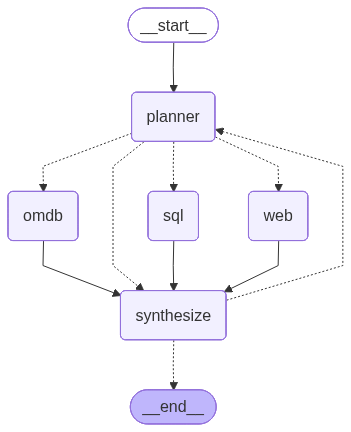

In [10]:
from IPython.display import Image, display

png_graph = app.get_graph().draw_mermaid_png()

display(Image(png_graph))

2025-11-15 20:03:52.005 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-15 20:03:52.006 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-15 20:03:52.349 
  command:

    streamlit run c:\Users\Vincent\GitHub\Vincent-20-100\Agentic_Systems_Project_Vlamy\.venv\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-11-15 20:03:52.350 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-15 20:03:52.350 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-15 20:03:52.351 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-15 20:03:52.351 Thread 'MainThread': missing Scrip

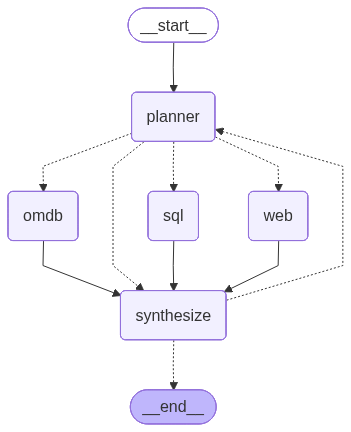

In [1]:
from IPython.display import Image, display
from albert_query_app import app

png_graph = app.get_graph().draw_mermaid_png()

#with open("../doc/graph_output.png", "wb") as f:
#    f.write(png_graph)
#    print("✅ Image sauvegardée : ../doc/graph_output.png")

display(Image(png_graph))

In [11]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage
import os
from dotenv import load_dotenv


load_dotenv()

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

chat = ChatOpenAI(model="gpt-4o", temperature=0, api_key=OPENAI_API_KEY)

messages = [
    SystemMessage(content="You're a helpful assistant"),
    HumanMessage(content="What are the hot research topics in 2025? Return your answer in 5 sentences and in bullet points."),
]

print(chat.invoke(messages).content)

As of my last update in October 2023, I can't predict the exact research topics that will be hot in 2025, but I can suggest some areas that are likely to continue being significant based on current trends:

- **Artificial Intelligence and Machine Learning**: Continued advancements in AI, particularly in areas like explainable AI, AI ethics, and AI applications in healthcare and autonomous systems, are expected to remain at the forefront of research.

- **Quantum Computing**: As quantum technology progresses, research into practical applications, error correction, and quantum algorithms is likely to be a major focus.

- **Sustainability and Climate Change**: Innovative solutions for renewable energy, carbon capture, and sustainable agriculture will be critical as the world seeks to address climate change and environmental challenges.

- **Biotechnology and Genomics**: Advances in CRISPR and other gene-editing technologies, personalized medicine, and synthetic biology are expected to dri